<a href="https://colab.research.google.com/github/HemaP-0303/ML_LAB/blob/main/1BM22CS111_9_ADABOOST_10_K_MEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.alphas = []
        self.models = []
    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.ones(n_samples) / n_samples
        for _ in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=1)
            model.fit(X, y, sample_weight=w)
            predictions = model.predict(X)
            err = np.sum(w * (predictions != y)) / np.sum(w)
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))
            self.alphas.append(alpha)
            self.models.append(model)
            w = w * np.exp(-alpha * y * predictions)
            w = w / np.sum(w)
    def predict(self, X):
        strong_preds = np.zeros(X.shape[0])
        for model, alpha in zip(self.models, self.alphas):
            strong_preds += alpha * model.predict(X)
        return np.sign(strong_preds).astype(int)
if __name__ == "__main__":

    X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    adaboost = AdaBoost(n_estimators=50)
    adaboost.fit(X_train, y_train)

    predictions = adaboost.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    try:
        roc_auc = roc_auc_score(y_test, predictions)
    except ValueError:
        roc_auc = 'Undefined (requires probability scores)'

    # Print results
    print(f"Accuracy: {accuracy * 100}%")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")

Accuracy: 84.0%
Precision: 0.8364779874213837
Recall: 0.8580645161290322
F1 Score: 0.8471337579617835
ROC-AUC: 0.839377085650723


Round 1 | Feature: MajorAxisLength, Threshold: 422.2791, Polarity: -1, Error: 0.1356, Alpha: 0.9264
Round 2 | Feature: Perimeter, Threshold: 1006.3750, Polarity: -1, Error: 0.3602, Alpha: 0.2872
Round 3 | Feature: Perimeter, Threshold: 1259.4510, Polarity: -1, Error: 0.3894, Alpha: 0.2250
Round 4 | Feature: MajorAxisLength, Threshold: 423.8444, Polarity: 1, Error: 0.3882, Alpha: 0.2274
Round 5 | Feature: Perimeter, Threshold: 912.2590, Polarity: -1, Error: 0.4009, Alpha: 0.2008

Accuracy: 86.56%
Precision: 0.8364
Recall: 0.9089
F1 Score: 0.8711
ROC-AUC: 0.9216


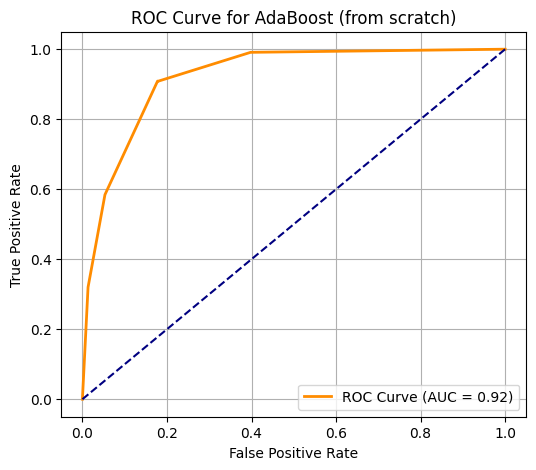

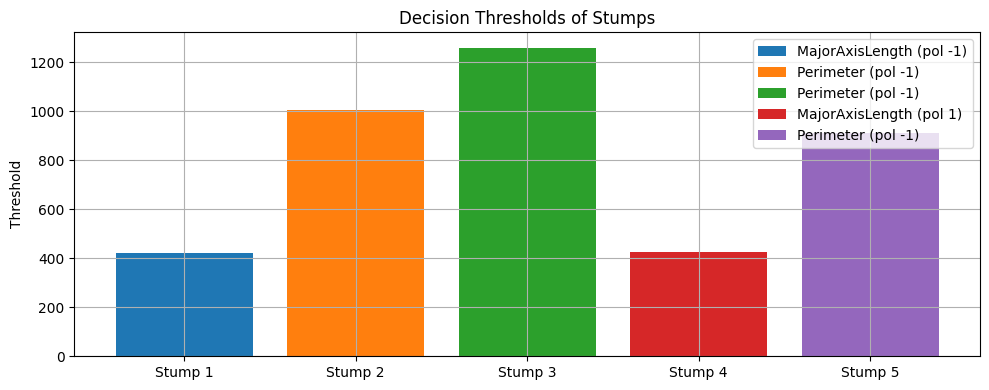

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# 1. Load the dataset
df = pd.read_excel("/content/Raisin_Dataset.xlsx")

# 2. Preprocess: Map class to binary labels
df['Label'] = df['Class'].map({'Kecimen': 1, 'Besni': -1})

# 3. Select features and labels
features = ['Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
            'ConvexArea', 'Extent', 'Perimeter']
X = df[features].values
y = df['Label'].values
n_samples, n_features = X.shape

# 4. AdaBoost from scratch
T = 5
weights = np.ones(n_samples) / n_samples
alphas = []
stumps = []

def decision_stump(X, y, weights):
    n_samples, n_features = X.shape
    best_feature, best_threshold, best_polarity, min_error = None, None, None, float('inf')

    for feature_i in range(n_features):
        feature_values = X[:, feature_i]
        thresholds = np.unique(feature_values)

        for threshold in thresholds:
            for polarity in [1, -1]:
                predictions = np.ones(n_samples)
                predictions[polarity * feature_values < polarity * threshold] = -1
                misclassified = predictions != y
                error = np.sum(weights * misclassified)

                if error < min_error:
                    min_error = error
                    best_feature = feature_i
                    best_threshold = threshold
                    best_polarity = polarity

    return best_feature, best_threshold, best_polarity, min_error

# Training
for t in range(T):
    feature, threshold, polarity, error = decision_stump(X, y, weights)
    alpha = 0.5 * np.log((1 - error + 1e-10) / (error + 1e-10))

    preds = np.ones(n_samples)
    preds[polarity * X[:, feature] < polarity * threshold] = -1

    weights *= np.exp(-alpha * y * preds)
    weights /= np.sum(weights)

    alphas.append(alpha)
    stumps.append((feature, threshold, polarity))

    print(f"Round {t+1} | Feature: {features[feature]}, Threshold: {threshold:.4f}, Polarity: {polarity}, Error: {error:.4f}, Alpha: {alpha:.4f}")

# Prediction function
def strong_classifier(X):
    final_pred = np.zeros(X.shape[0])
    for alpha, (feature, threshold, polarity) in zip(alphas, stumps):
        pred = np.ones(X.shape[0])
        pred[polarity * X[:, feature] < polarity * threshold] = -1
        final_pred += alpha * pred
    return np.sign(final_pred), final_pred  # Return raw scores for ROC

# Predict
y_pred, y_scores = strong_classifier(X)

# Metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
roc_auc = roc_auc_score(y, y_scores)

# Print metrics
print(f"\nAccuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y, y_scores)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for AdaBoost (from scratch)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Optional: Plot Decision Thresholds per stump
plt.figure(figsize=(10, 4))
for i, (feature, threshold, polarity) in enumerate(stumps):
    plt.bar(i, threshold, label=f"{features[feature]} (pol {polarity})")
plt.ylabel("Threshold")
plt.xticks(range(T), [f"Stump {i+1}" for i in range(T)])
plt.title("Decision Thresholds of Stumps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Initial Centroids:
[[60 52]
 [20 79]
 [30  4]
 [78  1]
 [71 11]]

Iteration 1 Centroids:
[[65.10569106 59.5203252 ]
 [25.72727273 79.36363636]
 [25.14285714 19.52380952]
 [97.41176471 13.29411765]
 [79.64705882 19.82352941]]

Iteration 2 Centroids:
[[ 66.13274336  61.2300885 ]
 [ 26.30434783  78.56521739]
 [ 28.          23.30769231]
 [103.78571429  19.42857143]
 [ 77.20833333  18.16666667]]

Iteration 3 Centroids:
[[ 65.3853211   61.19266055]
 [ 26.30434783  78.56521739]
 [ 28.96428571  24.92857143]
 [111.76923077  30.07692308]
 [ 78.37037037  17.55555556]]

Iteration 4 Centroids:
[[ 65.07476636  61.1682243 ]
 [ 26.30434783  78.56521739]
 [ 29.48275862  25.65517241]
 [115.16666667  36.75      ]
 [ 79.55172414  17.34482759]]

Iteration 5 Centroids:
[[ 63.90384615  60.74038462]
 [ 26.30434783  78.56521739]
 [ 29.48275862  25.65517241]
 [113.26666667  44.6       ]
 [ 79.55172414  17.34482759]]

Iteration 6 Centroids:
[[ 63.33653846  60.36538462]
 [ 26.30434783  78.56521739]
 [ 28.9642857

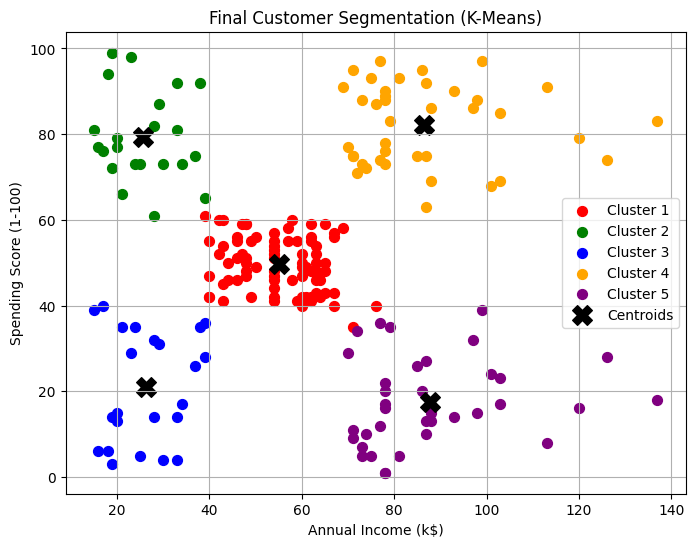

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv('/content/Mall_Customers.csv')
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

# Parameters
K = 5
MAX_ITER = 10
np.random.seed(42)

# Initialize centroids randomly
centroids = X[np.random.choice(X.shape[0], K, replace=False)]

print("Initial Centroids:")
print(centroids)

for iteration in range(MAX_ITER):
    # Step 1: Assign points to nearest centroid
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    labels = np.argmin(distances, axis=1)

    # Step 2: Calculate new centroids
    new_centroids = np.array([
        X[labels == k].mean(axis=0) if np.any(labels == k) else centroids[k]
        for k in range(K)
    ])

    print(f"\nIteration {iteration + 1} Centroids:")
    print(new_centroids)

    # Stop if centroids have converged
    if np.allclose(centroids, new_centroids):
        print("\nConverged.")
        break

    centroids = new_centroids

# Plot final clusters
colors = ['red', 'green', 'blue', 'orange', 'purple']
plt.figure(figsize=(8, 6))

for k in range(K):
    cluster_points = X[labels == k]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, color=colors[k], label=f'Cluster {k+1}')

# Plot final centroids
plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='black', marker='X', label='Centroids')

plt.title('Final Customer Segmentation (K-Means)')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid(True)
plt.show()